In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas
import matplotlib
import time

from cuqi.model import Model
from cuqi.distribution import Gaussian, JointDistribution
from cuqi.sampler import MetropolisHastings, NUTS
from cuqi.geometry import Continuous1D, Discrete

## 6. Case study: user-specified nonlinear model with a gravity anomaly

### 6.1. User-specified model
A subsurface body with a density contrast to its surroundings will cause a gravity anomaly. The gravity anomaly field depends on the body's depth, shape, size, and density constrast. 

We construct a simple example where a spherical body with radius $r=1000$ m, density constrast $\Delta\rho = 800$ $\text{kg}/\text{m}^3$, and center depth $z=1500$ m causes a gravity anomaly. This could represent a very simple model of iron ore embedded in sedimentary rock. The vertical gravity anomaly signal is then given by the function:
\begin{equation}
    F(z, \Delta\rho, r, \xi) = \frac{4\pi}{3} G \left(\frac{\Delta\rho r^3}{z^2}\right) \left(\frac{1}{1+(\xi/z)^2}\right)^{3/2}
\end{equation}
where $G$ is the gravitational constant and $\xi$ is the horizontal distance from the surface point above the centre of the body. See the problem illustrated in the figure further down.

In the inverse problem we measure the gravity anomaly at $m$ points $\xi_1, \dots, \xi_m$ along a line at the surface, intersecting the center of the body, to obtain data points $y_1,\dots, y_m$. From this data, we seek to infer $z$, $\Delta\rho$ and $r$. Then, the forward problem for one measurement point is given:
\begin{equation}
    y_i = F(z,\Delta\rho,r,\xi_i) \equiv A_i(\bm{x}) ,\qquad \bm{x} = [z,\Delta\rho,r]^{T},
\end{equation}
and hence the complete nonlinear forward model $\bm{A}: \mathbb{R}^3 \rightarrow \mathbb{R}^m$ is expressed:
\begin{equation}
    \bm{y} = \bm{A}(\bm{x}) =
    \begin{bmatrix} A_1(\bm{x}) \\ \vdots \\ A_m(\bm{x}) \end{bmatrix}.
\end{equation}
Note that the signal is uniquely determined from $z$ and the product $\Delta\rho r^3$, which means $z$ can be inferred from measurements, but $\Delta\rho$ and $r$ can not be resolved. 

To solve the inverse problem with CUQIpy we must define the non-linear forward model. The gravity anomali model is not included in the CUQIpy library, so we define it ourselves and wrap it as a CUQIpy model. Note that we also include the Jacobian of the model. This is nessecary to use gradient based samplers like NUTS later, but can be omitted if gradient based samplers are not needed. We also define the domain and range geometries of the model. The measurements are given by the continuous function (1) and the inferred parameters are different physical quantaties, making CUQIpy's Continuous1D and Discrete geometeries appropriate.

In [2]:
# Measurement grid
m = 100 # data dimension
xi = np.linspace(-8000, 8000, m)

# gravitational constant N m2 kg−2
G = 6.6743e-11 

# true parameters defining the subsurface body
n = 3 # parameter dimension
z_true = 1500 # depth in meters
rho_true = 800 # density contrast in kg m-3
r_true = 1000 # sphere radius in meters
x_true = np.array([z_true, rho_true, r_true])

# Forward model with parameter vector as input and measurements as output
def forward(wrt):
    z = wrt[0]
    rho = wrt[1]
    r = wrt[2]
    gz = 4/3*np.pi*G*(rho*r**3/z**2)*(1/(1+(xi/z)**2))**(3/2)
    return gz

# Gradient 
# For non-linear models it is defined from a product of the directional vector dir and the Jacobian of the model
def grad(dir, wrt):
    z = wrt[0]
    rho = wrt[1]
    R = wrt[2]

    grad_z = -4/3*np.pi*G*rho*R**3*z* (2*z**2-xi**2) * 1/(z**2/(xi**2+z**2))**(1/2) * 1/(xi**2+z**2)**3
    grad_rho = 4/3*np.pi*G*(R**3/z**2)*(1/(1+(xi/z)**2))**(3/2)
    grad_R = 4*np.pi*G*(rho*R**2/z**2)*(1/(1+(xi/z)**2))**(3/2)

    J = np.vstack([grad_z, grad_rho, grad_R]).T
    
    return dir@J

par_names = ["z", "rho", "r"]
domain_geometry = Discrete(par_names)
range_geometry = Continuous1D(m)

model = Model(forward, range_geometry=range_geometry, domain_geometry=domain_geometry, gradient=grad)

### 6.2. The Bayesian Problem
We define the data distribution and choose an appropriate prior. We will assume that the measurements are corrupted by Gaussian noise with standard deviation $10^{-6}$. And we choose a fairly uninformative prior, where the mean is offset from the true values and the spread is large.

In [3]:
prior_mean = np.array([1550, 850, 950])
prior_std = np.array([500, 300, 300])
x = Gaussian(prior_mean, sqrtcov = prior_std)

data_std = 1e-6
y = Gaussian(model(x), sqrtcov=data_std)

To solve the Bayesian Problem, we simulate a synthetic dataset by taking one realization from the data distribution evaluated at the true model parameters. We also evaluate the model at the true parameters, to obtain the ground truth. 

In [4]:
# Evalutate the model to get the noise free data
y_true = model(x_true)

# Sample from the data distribution to get noisy data
np.random.seed(0)
y_obs = y(x=x_true).sample()

Below we plot the gravity anomaly and the spherical body causing it.

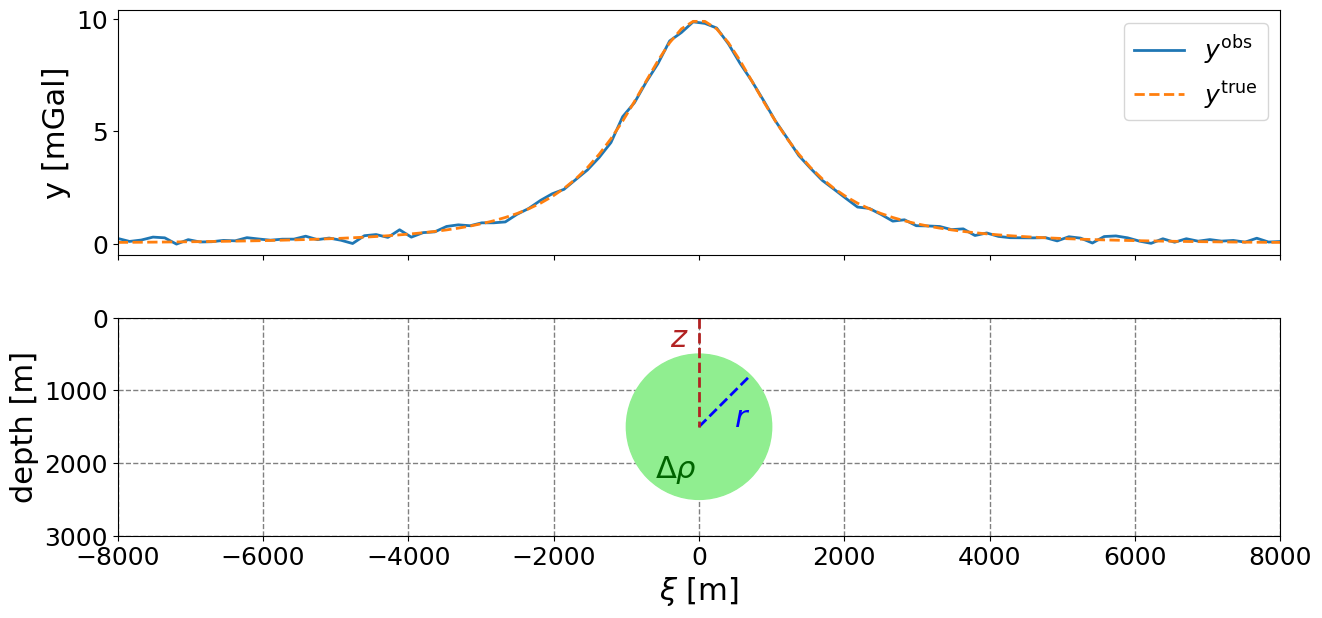

In [5]:
plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # fontsize of the legends

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (15,7), gridspec_kw={'height_ratios': [1, 1]})
circle = plt.Circle((0, -z_true), r_true, color='lightgreen')
ax[1].set_axisbelow(True)
ax[1].xaxis.grid(color='gray', linestyle='--', linewidth=1)
ax[1].yaxis.grid(color='gray', linestyle='--', linewidth=1)
ax[1].add_patch(circle)
ax[1].plot(np.array([0, r_true/np.sqrt(2)]), np.array([-z_true, -z_true+r_true/np.sqrt(2)]), color = "blue", linestyle = "--", linewidth = 2)
ax[1].plot(np.array([0, 0]), np.array([0, -z_true]), color = "firebrick", linestyle = "--", linewidth = 2)
ax[1].annotate(r"$r$", xy=(480,-1500), color = "blue")
ax[1].annotate(r"$\Delta \rho$", xy=(-600,-2200), color = "darkgreen")
ax[1].annotate(r"$z$", xy=(-400,-400), color = "firebrick")
ax[1].set_xlim(xi[0], xi[-1])
ax[1].set_ylim(-3000, 0)
ax[1].set_yticks([0,-1000,-2000,-3000])
ax[1].set_yticklabels([0,1000,2000,3000])
ax[1].set_xlabel(r"$\xi$ [m]")
ax[1].set_ylabel(r"depth [m]")
ax[1].set_aspect("equal")

ax[0].plot(xi,y_obs*1e5, label = r"$y^\mathrm{obs}$", linewidth = 2)
ax[0].plot(xi,y_true*1e5, label = r"$y^\mathrm{true}$", linewidth = 2, linestyle = "--")
ax[0].set_xticks(np.linspace(-8000, 8000, 9, endpoint = True))
ax[0].set_xlim(xi[0], xi[-1])
ax[0].set_xticklabels([])
ax[0].set_ylabel("y [mGal]")
ax[0].legend()

#### 6.3. Posterior sampling and analysis

From the prior and data distritbutions we form the posterior distribution and print CUQIpy's information about it.

In [6]:
# Form the posterior distribution
posterior = JointDistribution(x, y)(y=y_obs)
print(posterior)

Posterior(
    Equation:
	 p(x|y) ∝ L(x|y)p(x)
    Densities:
	y ~ CUQI Gaussian Likelihood function. Parameters ['x'].
 	x ~ CUQI Gaussian.
 )


##### 6.3.1. Metropolis-Hastings sampling

Then we sample the posterior using Metropolis-Hastings with adaptive step size. For that, we define a random seed, a starting point for the sampler and an initial step size. 

In [7]:
# Metropolis-Hastings sampling
x_init= np.array([1000,2000,1000])
scale_init = 100
np.random.seed(1000000)
MHsampler = MetropolisHastings(posterior, x0 = x_init, scale = scale_init)

t_start = time.time()
samplesMH = MHsampler.sample_adapt(1000000, 100000)
print("--- %s seconds ---" % (time.time() - t_start))


Sample 1100000 / 1100000

Average acceptance rate: 0.670925 MCMC scale: 1 

--- 589.7244589328766 seconds ---


/zhome/d2/8/97872/anaconda3/envs/cuqi/lib/python3.10/site-packages/cuqi/samples/_samples.py:474: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  if tight_layout: plt.tight_layout()


Correlation between parameters chains:
            z       rho         r
z    1.000000  0.003983  0.032845
rho  0.003983  1.000000 -0.981840
r    0.032845 -0.981840  1.000000

Depth effective sample size: 1849.9685098285686
Density contrast effective sample size: 7.788956499813224
Radius effective sample size: 7.807650395750149


Text(0, 0.5, 'Radius $r$ [m]')

<Figure size 640x480 with 0 Axes>

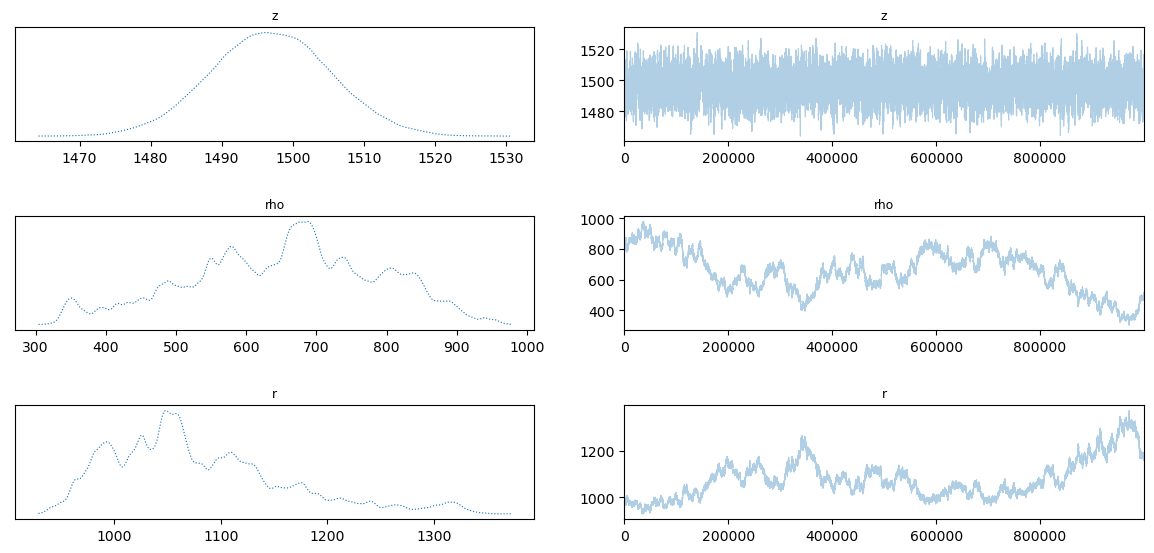

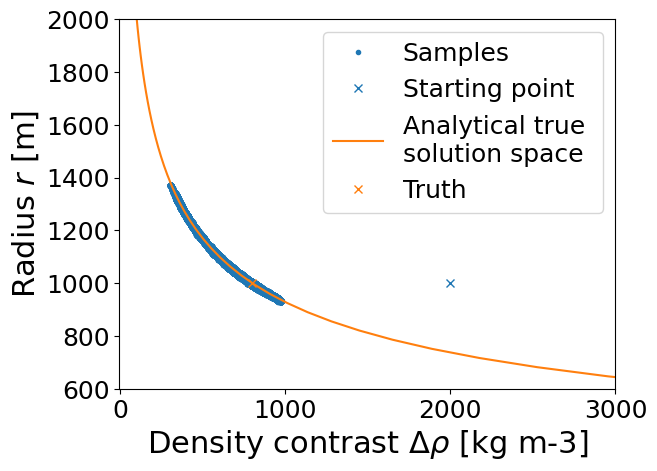

In [8]:
# Trace plots
plt.figure()
traceplot_MH = samplesMH.plot_trace()

# Correlation between parameters chains
corrcoefMH = np.corrcoef(samplesMH.samples)
print("Correlation between parameters chains:")
print(pandas.DataFrame(corrcoefMH, par_names, par_names))

# Effective sample size
ess_MH = samplesMH.compute_ess()
print("\nDepth effective sample size: {}".format(ess_MH[0]))
print("Density contrast effective sample size: {}".format(ess_MH[1]))
print("Radius effective sample size: {}".format(ess_MH[2]))

# 2D marginal of rho and r samples, to show they follow true solution space
fig, ax = plt.subplots(nrows = 1, ncols = 1)
cmap = plt.get_cmap("tab10")
ax.plot(samplesMH.samples[1,:], samplesMH.samples[2,:], '.', color = cmap(0), label = "Samples")
ax.plot(x_init[1], x_init[2], 'x', color = cmap(0), label = 'Starting point')
r_grid = np.linspace(300, 2000, 50)
ax.plot(rho_true*r_true**3/r_grid**3, r_grid, color = cmap(1), label = 'Analytical true \nsolution space')
ax.plot(rho_true, r_true, 'x', color = cmap(1), label = 'Truth')
ax.legend()
ax.set_xlim([-5,3000])
ax.set_ylim([600,2000])
ax.set_xlabel(r"Density contrast $\Delta\rho$ [kg m-3]")
ax.set_ylabel(r"Radius $r$ [m]")

In the 1D marginals (left in traceplots) we see that the posterior samples of the depth parameter constract near the true value and that the chain (right in traceplots) looks well mixed and with high effective sample size (ESS). The chains and 1D marginals for the other two parameters look poor and as if they have not converged and they have extremely low ESS. This is due to strong correlation between the density contrast and radius, which is confirmed by the computed correlation coefficients. From the model we can derive that the relationship between them is given $\Delta\rho = (\Delta\rho_{true} R_{true}^3)/R^3$. If we plot this curve along the 2D marginal of the samples, we see that they coincide. This means the sampler actually samples from the true solution space even though the chains look poor. However, the sampler moves slowly in the solution space and does not cover much of it. Eventually the samples would represent the entire posterior, but it will take a while. This is expected behaviour since Metropolis-Hastings is not a suitable sampler for highy correlated parameters.

##### 6.3.2. NUTS sampling
When the parameters are correlated, gradient based samplers are often more efficient for sampling the entire posterior. The gradient information helps the sampler move optimally in the low dimensional subspace. Below we use the NUTS sampler to sample and plot the posterior using the same starting point as for the Metropolis-Hastings sampler:

In [9]:
# NUTS sampling
np.random.seed(1000000)
NUTSsampler = NUTS(posterior, x0 = x_init)

t_start = time.time()
samplesNUTS = NUTSsampler.sample_adapt(8000, 100)
print("--- %s seconds ---" % (time.time() - t_start))


/zhome/d2/8/97872/anaconda3/envs/cuqi/lib/python3.10/site-packages/cuqi/sampler/_hmc.py:222: RuntimeWarning: overflow encountered in exp
  alpha_prime = min(1, np.exp(diff_Ham))     # logalpha_p = min(0, H_p - H)


Sample 8100 / 8100
--- 646.8984544277191 seconds ---


Correlation between parameters chains:
            z       rho         r
z    1.000000  0.032338 -0.002995
rho  0.032338  1.000000 -0.955053
r   -0.002995 -0.955053  1.000000

Depth effective sample size: 4151.359113737516
Density contrast effective sample size: 743.1324446306623
Radius effective sample size: 744.2770776242402


/zhome/d2/8/97872/anaconda3/envs/cuqi/lib/python3.10/site-packages/cuqi/samples/_samples.py:474: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  if tight_layout: plt.tight_layout()


<Figure size 640x480 with 0 Axes>

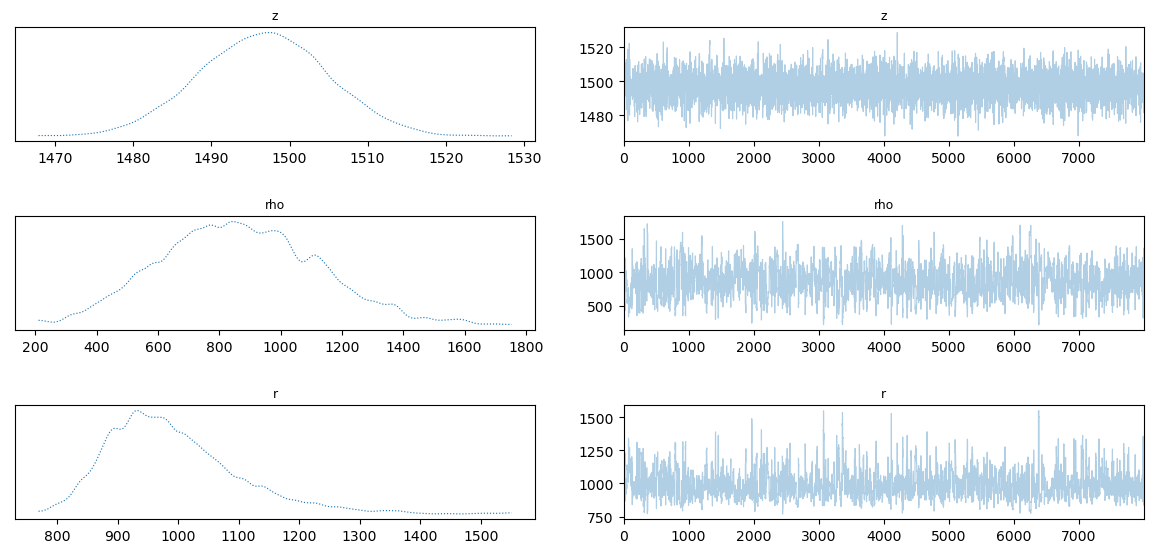

In [10]:
# Traceplots
plt.figure()
traceplot_NUTS = samplesNUTS.plot_trace()

# Correlation between parameters chains
corrcoefNUTS = np.corrcoef(samplesNUTS.samples)
print("Correlation between parameters chains:")
print(pandas.DataFrame(corrcoefNUTS, par_names, par_names))

# Effective sample size
ess_NUTS = samplesNUTS.compute_ess()
print("\nDepth effective sample size: {}".format(ess_NUTS[0]))
print("Density contrast effective sample size: {}".format(ess_NUTS[1]))
print("Radius effective sample size: {}".format(ess_NUTS[2]))


The 1D marginals and ESS show us that the NUTS sampler has much better chains than the Metropolis-Hastings sampler. Furthermore, NUTS also infers the depth parameter well, but the other two parameters have very wide spreads, which is due to the high correlation between these parameters. 
Also note, that while Metropolis-Hastings obtain many more samples than NUTS in $\approx 10$ minutes, the actual effective sample size is higher for NUTS.

##### 6.3.3. More informative prior

We saw that the density contrast and radius can not be determined uniquely from the data. Our only hope to improve the solution is with a good prior. We formulate a Gaussian prior to imitate the situation where we are quite sure about the density contrast, but not the radius or depth. This might happen if we know we are looking for iron ore in sedimentary rock, but not how much or how deep down.

We redefine the prior and posterior and sample with NUTS.

In [11]:
# Prior
prior_mean2 = np.array([1550, 800, 950])
prior_std2 = np.array([500, 30, 300])
x = Gaussian(prior_mean2 , sqrtcov = prior_std2)

# Posterior
posterior = JointDistribution(x, y)(y=y_obs)

# Sample
np.random.seed(1000000)
NUTSsampler2 = NUTS(posterior, x0 = x_init)

t_start = time.time()
samplesNUTS2 = NUTSsampler2.sample_adapt(8000, 100)
print("--- %s seconds ---" % (time.time() - t_start))


/zhome/d2/8/97872/anaconda3/envs/cuqi/lib/python3.10/site-packages/cuqi/sampler/_hmc.py:222: RuntimeWarning: overflow encountered in exp
  alpha_prime = min(1, np.exp(diff_Ham))     # logalpha_p = min(0, H_p - H)


Sample 8100 / 8100
--- 132.62309074401855 seconds ---


Correlation between parameters chains:
            z       rho         r
z    1.000000 -0.006636  0.222403
rho -0.006636  1.000000 -0.972647
r    0.222403 -0.972647  1.000000

Depth effective sample size: 3859.9953632868865
Density contrast effective sample size: 991.4912128924983
Radius effective sample size: 1019.3862601966655


/zhome/d2/8/97872/anaconda3/envs/cuqi/lib/python3.10/site-packages/cuqi/samples/_samples.py:474: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  if tight_layout: plt.tight_layout()


<Figure size 640x480 with 0 Axes>

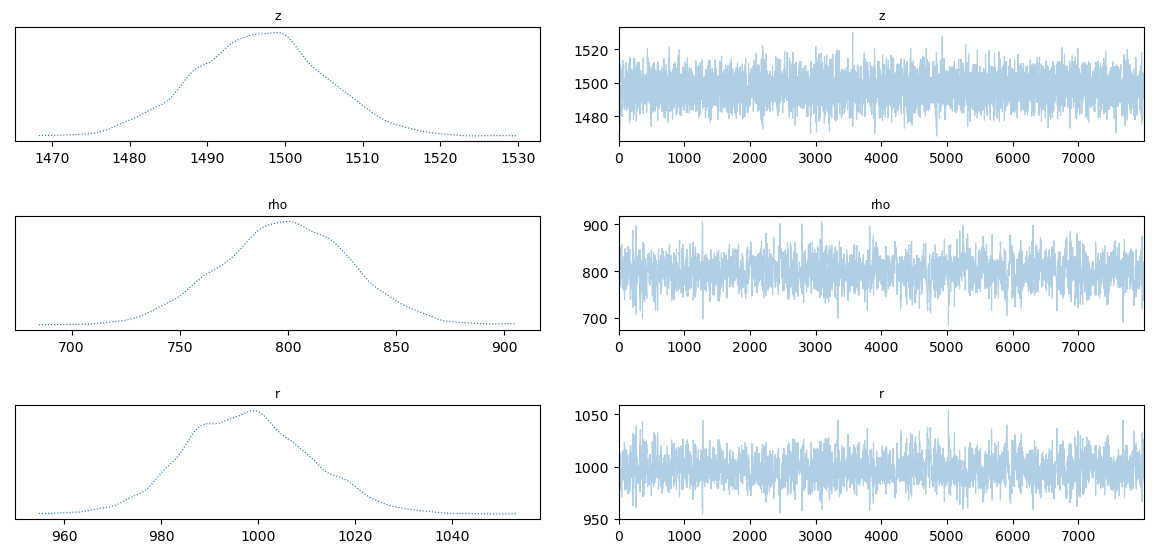

In [12]:
# Traceplots
plt.figure()
traceplot_NUTS2 = samplesNUTS2.plot_trace()

# Correlation between parameters chains
corrcoefNUTS2 = np.corrcoef(samplesNUTS2.samples)
print("Correlation between parameters chains:")
print(pandas.DataFrame(corrcoefNUTS2, par_names, par_names))

# Effective sample size
ess2 = samplesNUTS2.compute_ess()
print("\nDepth effective sample size: {}".format(ess2[0]))
print("Density contrast effective sample size: {}".format(ess2[1]))
print("Radius effective sample size: {}".format(ess2[2]))

We see that the more informative prior on the density contrast, leads to the radius being inferred much better. 

##### 6.3.4. Plot 

Below we plot the 1D marginals and chains together for all experiments for easy comparison. The plots are taken from CUQIpy's traceplot() functionality. 

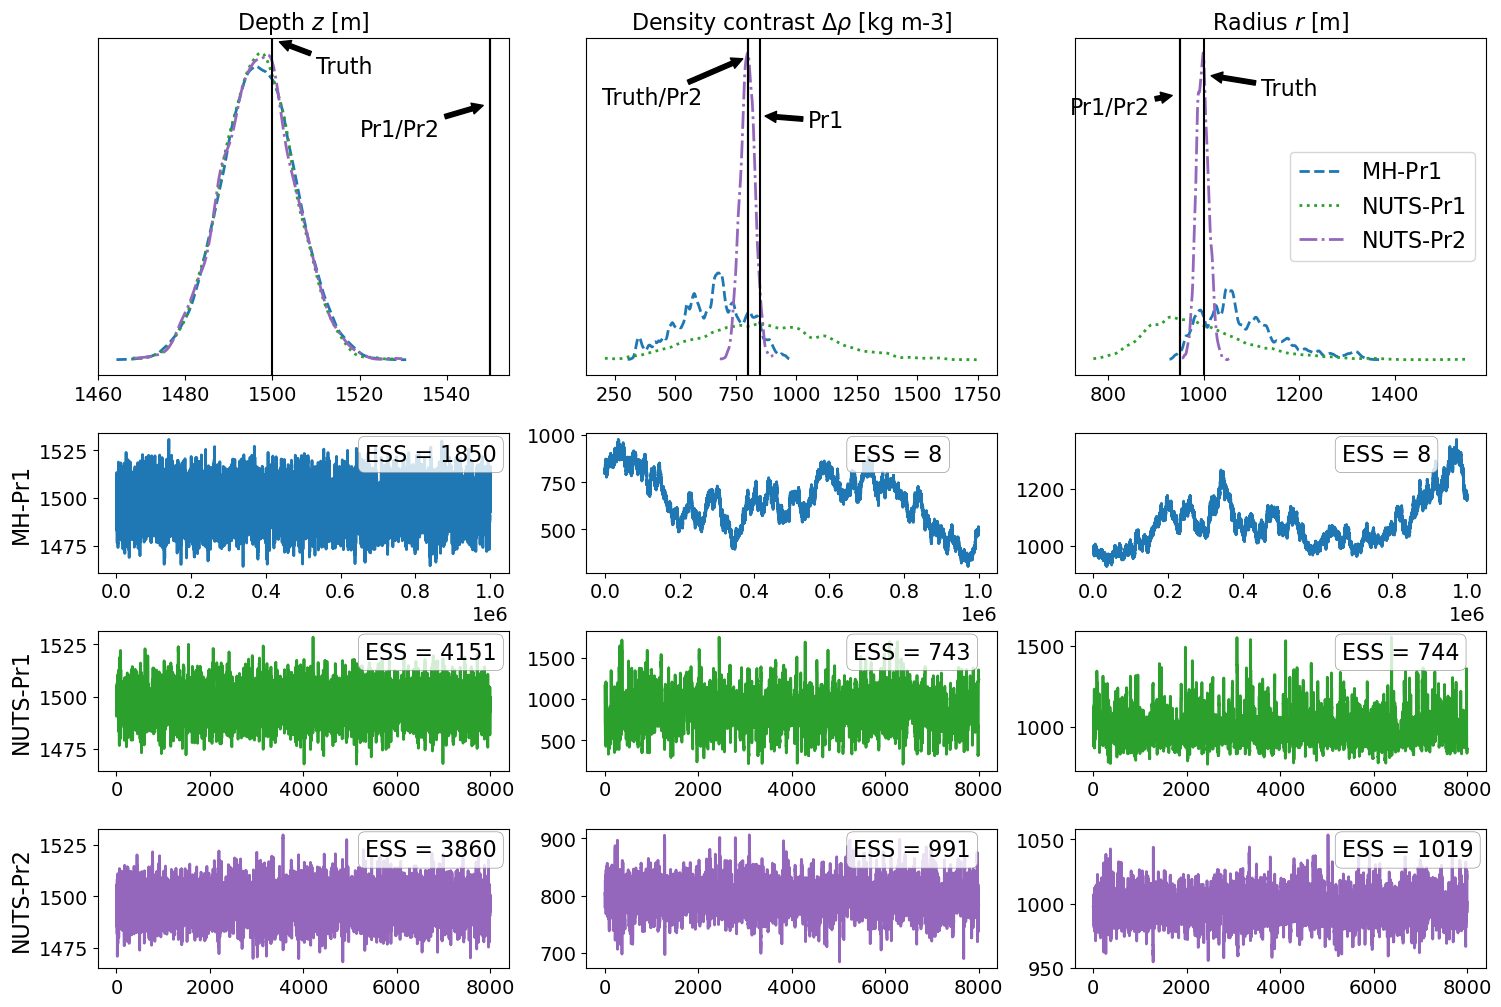

In [13]:
fig = plt.figure(figsize = (15,10))
gs = matplotlib.gridspec.GridSpec(5, 3, figure=fig)
ax1 = fig.add_subplot(gs[0:2, 0]) # 1D marginal z
ax2 = fig.add_subplot(gs[0:2, 1]) # 1D marginal rho
ax3 = fig.add_subplot(gs[0:2, 2]) # 1D marginal R
ax4 = fig.add_subplot(gs[2, 0]) # z MH chain
ax5 = fig.add_subplot(gs[3, 0]) # z NUTS1 chain
ax6 = fig.add_subplot(gs[4, 0]) # z NUTS2 chain
ax7 = fig.add_subplot(gs[2, 1]) # rho MH chain
ax8 = fig.add_subplot(gs[3, 1]) # rho NUTS1 chain
ax9 = fig.add_subplot(gs[4, 1]) # rho NUTS2 chain
ax10 = fig.add_subplot(gs[2, 2]) # r MH chain
ax11 = fig.add_subplot(gs[3, 2]) # r NUTS1 chain
ax12 = fig.add_subplot(gs[4, 2]) # r NUTS2 chain


cmap = plt.get_cmap("tab10")

ticksize = 14
legendsize = 16
titlesize = 16

x_true = np.array([z_true, rho_true, r_true])
for i, ax in enumerate([ax1, ax2, ax3]):
    tmp_MH = traceplot_MH[i,0].get_lines()[0].get_data()
    tmp_NUTS = traceplot_NUTS[i,0].get_lines()[0].get_data()
    tmp_NUTS2 = traceplot_NUTS2[i,0].get_lines()[0].get_data()
    ax.plot(tmp_MH[0],tmp_MH[1], color = cmap(0), linestyle = "dashed", linewidth = 2, label = r"MH-Pr$1$")
    ax.plot(tmp_NUTS[0],tmp_NUTS[1], color = cmap(2), linestyle = "dotted", linewidth = 2, label = r"NUTS-Pr$1$")
    ax.plot(tmp_NUTS2[0],tmp_NUTS2[1], color = cmap(4), linestyle = "dashdot", linewidth = 2, label = r"NUTS-Pr$2$")
    ax.axvline(x = x_true[i], color = 'k', linestyle = "solid", linewidth = 1.5)
    ax.axvline(x = prior_mean[i], color = 'k', linestyle = 'solid', linewidth = 1.5)
    ax.axvline(x = prior_mean2[i], color = 'k', linestyle = "solid", linewidth = 1.5)
    ax.set_yticks([])
    ax.tick_params(axis='both', which='both', labelsize=ticksize)

for i, ax in enumerate([ax4, ax7, ax10]):
    tmp_MH = traceplot_MH[i,1].get_lines()[0].get_data()
    ax.plot(tmp_MH[0],tmp_MH[1], color = cmap(0), linewidth = 2)
    ax.annotate("ESS = {}".format(round(ess_MH[i])), (0.65, 0.8), xycoords="axes fraction", bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha = 0.8, lw=0.5), fontsize = legendsize)
    ax.tick_params(axis='both', which='both', labelsize=ticksize)
    ax.xaxis.offsetText.set_fontsize(ticksize)

for i, ax in enumerate([ax5, ax8, ax11]):
    tmp_NUTS = traceplot_NUTS[i,1].get_lines()[0].get_data()
    ax.plot(tmp_NUTS[0],tmp_NUTS[1], color = cmap(2), linewidth = 2)
    ax.annotate("ESS = {}".format(round(ess_NUTS[i])), (0.65, 0.8), xycoords="axes fraction", bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha = 0.8, lw=0.5), fontsize = legendsize)
    ax.tick_params(axis='both', which='both', labelsize=ticksize)

for i, ax in enumerate([ax6, ax9, ax12]):
    tmp_NUTS2 = traceplot_NUTS2[i,1].get_lines()[0].get_data()
    ax.plot(tmp_NUTS2[0],tmp_NUTS2[1], color = cmap(4), linewidth = 2)
    ax.annotate("ESS = {}".format(round(ess2[i])), (0.65, 0.8), xycoords="axes fraction", bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha = 0.8, lw=0.5), fontsize = legendsize)
    ax.tick_params(axis='both', which='both', labelsize=ticksize)

ax1.annotate('Truth', xy =(x_true[0]+1, 0.05), xytext =(x_true[0]+10, 0.045), arrowprops=dict(facecolor='black',arrowstyle="simple"), fontsize = legendsize)
ax1.annotate('Pr1/Pr2', xy =(prior_mean[0]-1, 0.04), xytext =(prior_mean[0]-30, 0.035), arrowprops=dict(facecolor='black',arrowstyle="simple"), fontsize = legendsize)

ax2.annotate('Truth/Pr2', xy =(x_true[1]-10, 0.013), xytext =(x_true[1]-600, 0.011), arrowprops=dict(facecolor='black',arrowstyle="simple"), fontsize = legendsize)
ax2.annotate('Pr1', xy =(prior_mean[1]+10, 0.0105), xytext =(prior_mean[1]+200, 0.01), arrowprops=dict(facecolor='black',arrowstyle="simple"), fontsize = legendsize)

ax3.annotate('Truth', xy =(x_true[2]+10, 0.029), xytext =(x_true[2]+120, 0.027), arrowprops=dict(facecolor='black',arrowstyle="simple"), fontsize = legendsize)
ax3.annotate('Pr1/Pr2', xy =(prior_mean[2]-10, 0.027), xytext =(prior_mean[2]-230, 0.025), arrowprops=dict(facecolor='black',arrowstyle="simple"), fontsize = legendsize)

ax3.legend(fontsize = legendsize, loc = 'center right')

ax1.set_title(r"Depth $z$ [m]", fontsize = titlesize)
ax2.set_title(r"Density contrast $\Delta\rho$ [kg m-3]", fontsize = titlesize)
ax3.set_title(r"Radius $r$ [m]", fontsize = titlesize)

#ax1.set_ylabel(r"1D marginals", fontsize = titlesize)
ax4.set_ylabel(r"MH-Pr1", fontsize = titlesize)
ax5.set_ylabel(r"NUTS-Pr1", fontsize = titlesize)
ax6.set_ylabel(r"NUTS-Pr2", fontsize = titlesize)

fig.tight_layout(pad=0.2)